In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook
import matplotlib as mpl
import scipy.signal as signal
import numba
from numba import jit
import popdyn
import popdyn.convolve as cv
import copy
from importlib import reload

plt.rcParams["animation.html"] = "jshtml"

In [6]:
"""
A simple example of an animated plot
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def animate(i):
    line.set_ydata(np.sin(x + i/10.0))  # update the data
    return line,


# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init,
                              interval=25, blit=True)
plt.close()
ani

# The fiducial maps

In [8]:
map_oceans = plt.imread("../maps/LOTR_MAPS_oceans.png")
map_rivers = plt.imread("../maps/LOTR_MAPS_rivers.png")
map_hills = plt.imread("../maps/LOTR_MAPS_hills.png")
map_mountains = plt.imread("../maps/LOTR_MAPS_mountains.png")
map_ridges = plt.imread("../maps/LOTR_MAPS_ridges.png")

wmap_oceans = popdyn.reader.extract_weightmap(map_oceans)
wmap_rivers = popdyn.reader.extract_weightmap(map_rivers)
wmap_hills = popdyn.reader.extract_weightmap(map_hills)
wmap_mountains = popdyn.reader.extract_weightmap(map_mountains)
wmap_ridges = popdyn.reader.extract_weightmap(map_ridges)

wmap_land = popdyn.reader.invert_weightmap(wmap_oceans)

In [9]:
raw_elevation = np.load("lotr_map_raw_elevation.npz")["arr_0"]

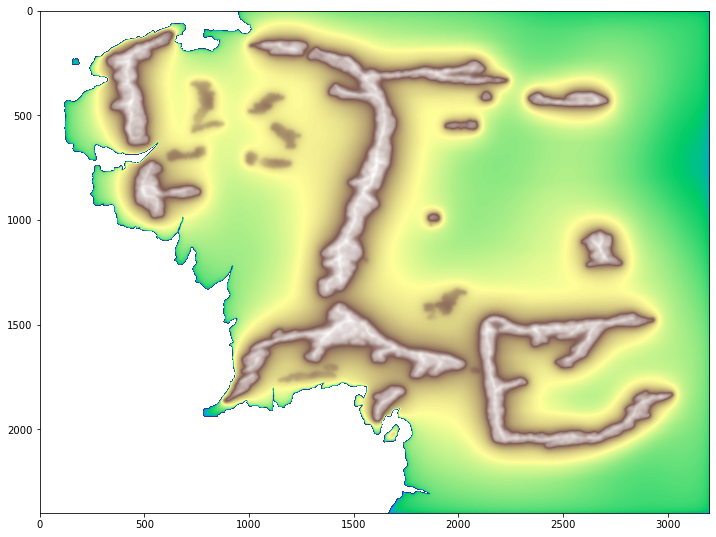

In [10]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(raw_elevation -1, cmap=plt.cm.terrain, norm=mpl.colors.LogNorm())
fig.savefig("map.png")

# cell automata erosion model

In [23]:
raw_elevation[:1]

array([[ 0.        ,  0.        ,  0.        , ..., 46.42529956,
        44.84182779, 43.20473578]])

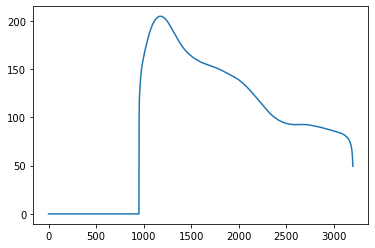

In [31]:
plt.plot(raw_elevation[4].T[:])

In [15]:
raw_elevation[:1].shape


(1, 3200)

In [78]:
arr = np.arange(25).reshape(5, 5)

In [79]:
arr

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [80]:
    def shift_array(self, array, place):
        new_arr = np.roll(array, place, axis=0)
        new_arr[:place] = np.zeros((new_arr[:place].shape))
        return new_arr

In [81]:
tmp = np.roll(arr, -1, axis=0)

In [82]:
tmp[-1:, :] = 0

In [76]:
tmp

array([[ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24],
       [ 0,  0,  0,  0,  0]])

In [125]:
class CellStep(object):
    def __init__(self, canvas, rainmap, rulefunc=None):
        self.canvas = canvas
        self.rulefunc = rulefunc
        self.shifted_canvases = []
        self.rain_pattern = rainmap
        self.watermap = rainmap
        
        
        self.imap = np.arange(len(self.canvas.flatten())).reshape(self.canvas.shape)
        self.imap_shifted = self.calc_shifted(self.imap)
        
    def calc_shifted(self, inmap):
        """shift up, down, left, right"""

        omap = []
        tmp = np.roll(inmap, -1, axis=0)
        tmp[-1:, :] = 0
        omap.append(tmp)
        
        tmp = np.roll(inmap, 1, axis=0)
        tmp[:1, :] = 0
        omap.append(tmp)
        
        tmp = np.roll(inmap, -1, axis=1)
        tmp[:, -1:] = 0
        omap.append(tmp)        
        
        tmp = np.roll(inmap, 1, axis=1)
        tmp[:, :1] = 0
        omap.append(tmp)     
        return np.array(omap)
        
    
    def flow(self):
        """
        Water flows downhill into the ocean, from each point on and on
        
        
        This is the from out to in phylosophy, where water flow is calculated from other to here for each cell
        
        This is equivalent to the in to out phylosophy, just easier to implement vectorized
        """
        
        self.watermap += self.rain_pattern # at each moment, a new rain falls according to the rain pattern
        self.height_local = self.canvas + self.watermap
        self.height_shifted = self.calc_shifted(self.height_local)
        
        
        diffs = np.min((self.height_shifted - self.height_local))
        
        
        # find how much water is going to outflow, this is the total difference between heights here and elsewhere
        
        
        
        # From this cell the excess water is split to go to each other cell
        
        
        # rain disappears into the ocean
        ii = self.watermap * self.canvas
        sel
    
        
        

In [126]:
rain_map = np.ones(raw_elevation.shape) # the typical rainfall is about a meter a year at each point|
cs = CellStep(raw_elevation, rain_map)

In [127]:
cs.flow()

In [156]:
(cs.height_shifted - cs.height_local)[:, 1367, 2039]

array([-2.00984473,  2.41566269, -3.10776681,  3.1740031 ])

In [162]:
arr = (cs.height_shifted - cs.height_local)
arr[arr < 0] = 0
fractions = np.nan_to_num(arr / arr.sum(axis=0))


/tmp/ipykernel_5702/1414338804.py:3: RuntimeWarning: invalid value encountered in true_divide
  fractions = np.nan_to_num(arr / arr.sum(axis=0))


In [163]:
fractions[:, 1367, 2039]

array([0.        , 0.43216585, 0.        , 0.56783415])

In [155]:
arr.sum(axis=0)

array([[0.        , 0.        , 0.        , ..., 3.4468408 , 3.37588432,
        3.26840644],
       [0.        , 0.        , 0.        , ..., 3.52129778, 3.46884133,
        3.37625141],
       [0.        , 0.        , 0.        , ..., 3.55242404, 3.5216352 ,
        3.44754614],
       ...,
       [0.        , 0.        , 0.        , ..., 3.63886511, 3.60750704,
        3.53233932],
       [0.        , 0.        , 0.        , ..., 3.60597052, 3.55295403,
        3.45932254],
       [0.        , 0.        , 0.        , ..., 3.52945915, 3.45796924,
        3.34950244]])

In [146]:
arrsum[1367, 2039]

5.589665794731502

In [143]:
fractions[:, 1367, 2039]

array([0.00000000e+00, 3.18717714e-08, 0.00000000e+00, 4.18771635e-08])

In [129]:
cs.imap_shifted[:, 1367, 2039]

array([4379639, 4373239, 4376440, 4376438])

In [124]:
cs.imap_shifted

array([[[ 0.        ,  0.        ,  0.        , ..., 48.37134292,
         46.63424035, 44.83605021],
        [ 0.        ,  0.        ,  0.        , ..., 50.24970621,
         48.3659791 , 46.41411149],
        [ 0.        ,  0.        ,  0.        , ..., 52.02342861,
         50.0038872 , 47.90979001],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., 56.47540877,
         54.70913541, 52.88162509],
        [ 0.        ,  0.        ,  0.        , ..., 54.47433238,
         52.86274927, 51.19743596],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., 46.42529956,
         44.84182779, 43.20473578],
        [ 0.        ,  0.        ,  0.        , ..., 48.37134292,
         46.63424035, 44.83605021],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., 6